In [1]:
%reload_ext autoreload
%autoreload

In [2]:
import keras
import tensorflow as tf
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, Dropout, BatchNormalization
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model, Sequential
from keras.datasets import cifar10
import numpy as np
import os

Using TensorFlow backend.


In [3]:
import keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
from keras.preprocessing import image
import autoreload
from utils import *

In [4]:
num_class = 10
index_to_label = {0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}
label_to_index = {u:v for v,u in index_to_label.items()}

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
input_shape = x_train.shape[1:]
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
# Subtracting pixel mean improves accuracy
x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean
x_test -= x_train_mean

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_class)
y_test = keras.utils.to_categorical(y_test, num_class)

model = resnet_v1(input_shape=input_shape, depth = 3*6+2)
model.load_weights('cifar10resnet_weights.h5')

convLayers = []
for i in range(len(model.layers)):
    if "add" in model.layers[i].name:
        convLayers.append(model.layers[i+1])

In [127]:
#only one gradient in outputs no subtracting the mean across coonductance to all pre-softmax score
input_tensor, outputs, sess = layerInit(model, num_class,  convLayers[-3:], True)
allClassCond2 = []
for c in range(num_class):
    print(c)
    classCond = []
    i = 0
    while len(classCond) != 1000:
        print(i, end = '\r')
        array = x_train[i]
        pred = np.argmax(model.predict(array[None]))
        if (pred == np.argmax(y_train[i])) & (pred == c):
            grads, activs = integratedGrad(array, input_tensor, [outputs[pred], outputs[-1]], sess)
            grads = np.array(grads)
            activs = np.array(activs)
            delta_activs = activs[:,1:,:,:,:] - activs[:,:-1,:,:,:]
            contribs = np.sum(grads[:,:,1:,:,:]*delta_activs, axis = 2)
            contribs = np.mean(contribs, axis = (0,2,3))
            classCond.append(contribs)
        i += 1
    allClassCond2.append(classCond)

0
11276
20771
32219
46983
51435
63257
70009
81648
90096


In [128]:
pickle.dump(allClassCond2, open('allClassCond2.p', 'wb'))

In [5]:
allClassCond2 = pickle.load(open('allClassCond2.p', 'rb'))

In [6]:
#catching the mean of every fm across all positive img
allFmMean2 = []
for c in range(num_class):
    classFmMean = []
    classCond = allClassCond2[c]
    for l in range(len(convLayers)):
        grouping = np.array([classCond[i][l] for i in range(len(classCond))])
        mean = np.mean(grouping, axis = 0)
        classFmMean.append(mean)
    allFmMean2.append(classFmMean)

In [7]:
#calc the mean of a fm across all classes
allClassMeans2 = []
for l in range(len(convLayers)):
    to = np.array([allFmMean2[c][l] for c in range(num_class)])
    to = np.mean(to, axis = 0)
    allClassMeans2.append(to)

In [8]:
#substracting the average cond across classes of a fm to this fm
#then rank all fm of all layer and classes
for c in range(num_class):
    for l in range(len(convLayers)):
        allFmMean2[c][l] -= allClassMeans2[l]
        allFmMean2[c][l] = list(allFmMean2[c][l])
        allFmMean2[c][l] = [(i, allFmMean2[c][l][i]) for i in range(len(allFmMean2[c][l]))]
        allFmMean2[c][l] = sorted(allFmMean2[c][l], key = lambda x: x[1], reverse = True)

In [9]:
#check top fm for all classes
topFMs2 = []
for l in range(len(convLayers)):
    cTop = []
    for c in range(num_class):
        cac = allFmMean2[c][l][:4]
        cac = [ca[0] for ca in cac]
        cTop.append(cac)
    topFMs2.append(cTop)
topFMs2 = np.array(topFMs2)

In [130]:
#reformating allClassCond2 to use layerTopCond function on it
allClassCond3 = []
for c in range(num_class):
    classCond = []
    for contrib in allClassCond2[c]:
        layer = []
        for l in range(len(convLayers[-3:])):
            contribL = list(contrib[l])
            contribL = [(i, contribL[i]) for i in range(len(contribL))]
            contribL = sorted(contribL, key = lambda x: x[1], reverse = True)
            layer.append(contribL)
        classCond.append(layer)
    allClassCond3.append(classCond)

In [ ]:
allClassCond3 = []
for c in range(num_class):
    classCond = []
    for contrib in wrongs[c]:
        layer = []
        for l in range(len(convLayers)):
            contribL = list(contrib[l])
            contribL = [(i, contribL[i]) for i in range(len(contribL))]
            contribL = sorted(contribL, key = lambda x: x[1], reverse = True)
            layer.append(contribL)
        classCond.append(layer)
    allClassCond3.append(classCond)

In [ ]:
allTopWrong = []
for Class in allClassCond3:
    allTopWrong.append(layerTopCond(Class, 2, convLayers))

In [133]:
#layerTopCond used on conductance without substracting the mean across all classes
allTop2 = []
for Class in allClassCond3:
    allTop2.append(layerTopCond(Class, 2, convLayers[-3:]))

In [87]:
#reformatting allTopTrain to calc all FMs mean 
nk = []
for c in range(num_class):
    fh = []
    for i in range(len(allTopTrain[c])):
        tu = []
        for l in range(len(convLayers)):
            mo = allTopTrain[c][i][l]
            mo = sorted(mo, key = lambda x: x[0])
            mo = [mj[1] for mj in mo]
            tu.append(mo)
        fh.append(tu)
    nk.append(fh)

In [88]:
#calc all FMs mean across all positive imgs
allFmMean = []
for c in range(num_class):
    classFmMean = []
    nkk = nk[c]
    for l in range(len(convLayers)):
        nkkk = np.array([nkk[i][l] for i in range(len(nkk))])
        mean = np.mean(nkkk, axis = 0)
        classFmMean.append(mean)
    allFmMean.append(classFmMean)

In [89]:
#calc the mean of FMs across all classes
layerMeans = []
for l in range(len(convLayers)):
    to = np.array([allFmMean[c][l] for c in range(num_class)])
    to = np.mean(to, axis = 0)
    layerMeans.append(to)

In [90]:
#substract the mean across classes to the mean across all positive img of one class
for c in range(num_class):
    for l in range(len(convLayers)):
        allFmMean[c][l] -= layerMeans[l]
        allFmMean[c][l] = list(allFmMean[c][l])
        allFmMean[c][l] = [(i, allFmMean[c][l][i]) for i in range(len(allFmMean[c][l]))]
        allFmMean[c][l] = sorted(allFmMean[c][l], key = lambda x: x[1], reverse = True)

CHECK IF AN IMAGE IS CONTESTED

In [8]:
allTopTrain = pickle.load(open('train_cond.p','rb'))
allTop = []
for Class in allTopTrain:
    allTop.append(layerTopCond(Class, 2, convLayers))

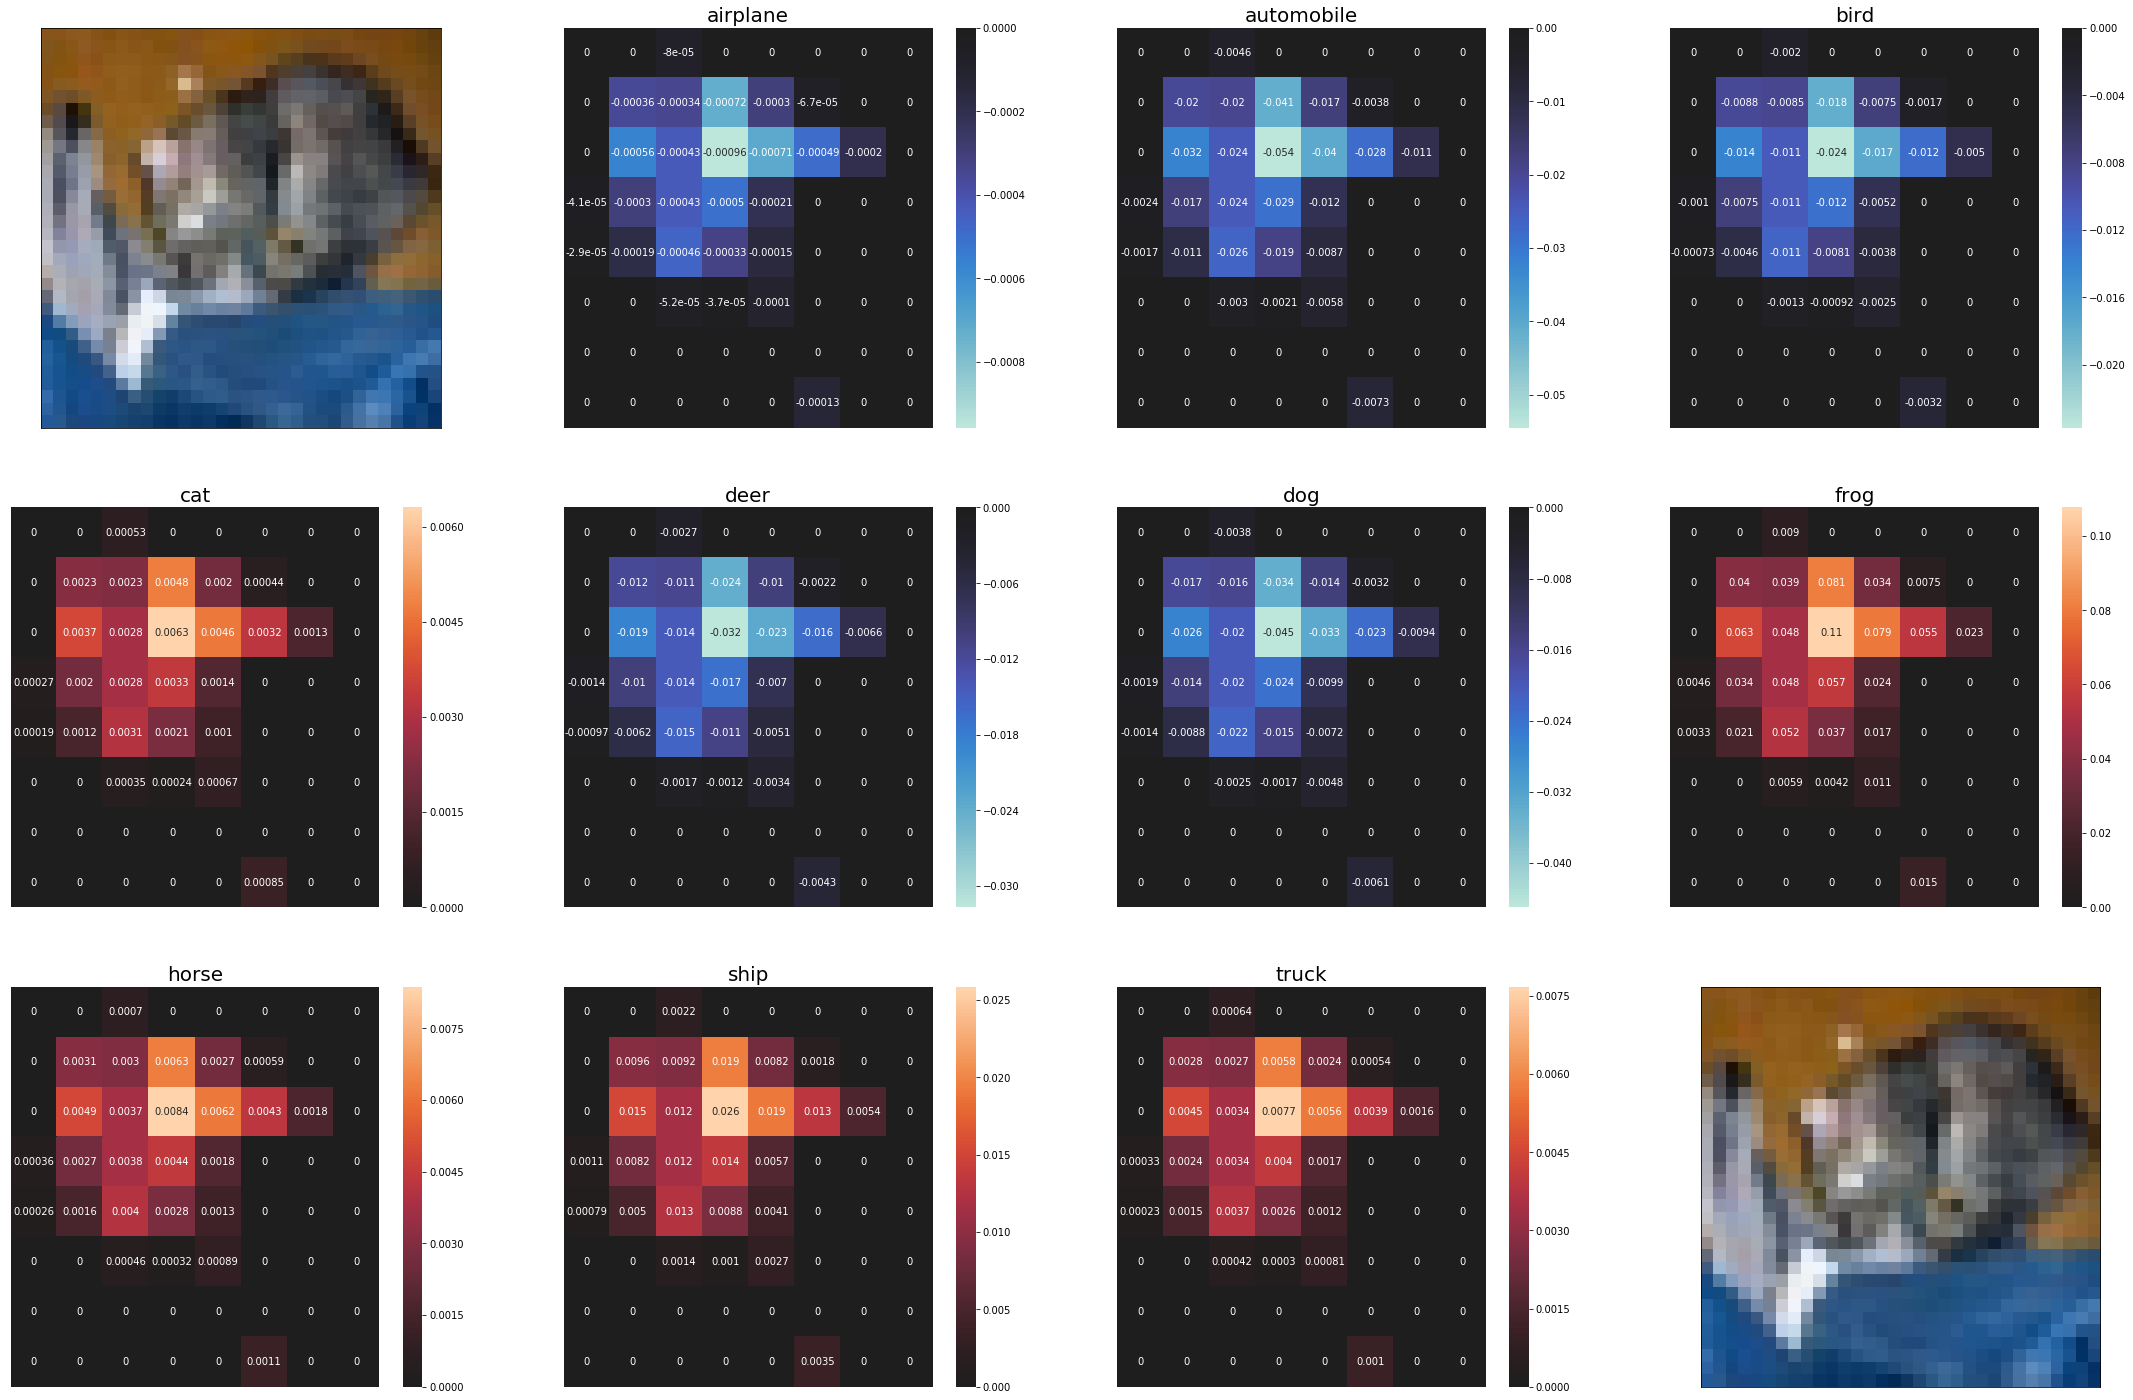

In [13]:
array = x_test[0]
res = model.predict(np.expand_dims(array,0))
pred = np.argmax(res)
fm = list(allTop[pred]['conv8'].keys())
heatmaps = condHeat(array, model, num_class, convLayers, fm = fm[0])
condViz(heatmaps,array, num_class, index_to_label, figsize = (38,25),xAxis = 4)

In [6]:
binary = load_binary('verif_weight_train_cond_data_augment.h5')

In [12]:
test_cond = pickle.load(open('test_cond.p', 'rb'))
test_index = pickle.load(open('test_index.p', 'rb'))
L = []
for c in range(num_class):
    L.extend(test_index[c])
#rank = [4,4,4,4,4,4,4,4,4]
# topFMs, topMeans = extractTop(rank, convLayers, allTop, num_class)
# finalTestCond = process_cond(convLayers,topFMs, topMeans, test_cond, num_class)

In [ ]:
    array = load_array(class_ind, img_ind, path)
    pred = int(train_pred[class_ind, img_ind])
    prob = train_proba[class_ind, img_ind]
    
    sess = K.get_session()
    input_tensor = model.layers[0].input
    inter_tensors = [convOut.output]
    output_tensor = model.layers[-2].output
    outputs = [tf.gradients(output_tensor[:,pred],inter_tensors), inter_tensors]
    
    grads, activs = integrated_gradient(array, input_tensor, outputs, sess)
    grads, activs = np.array(grads), np.array(activs)
    delta_activs = activs[:,1:,:,:,:] - activs[:,:-1,:,:,:] #shape = (n-1,128,128,3)
    contribs = np.sum(grads[:,:,1:,:,:,:]*delta_activs, axis = 2)
    contribs = np.squeeze(contribs, axis = (0,1))
    
    topFMs_pred = topFMs[layer,pred,:]
    contribs_pred = [contribs[:,:,fm] for fm in topFMs_pred]
    
    print("predicted as \'"+index_to_label[pred]+"\' with proba "+str(prob))
    print("is actually \'"+index_to_label[class_ind]+'\'')
    fig, axes = plt.subplots(1,len(topFMs_pred)+1, figsize = figsize)
    axes[0].imshow(image.array_to_img(array))
    axes[0].grid(False)
    axes[0].set_xticks([])
    axes[0].set_yticks([])

    for i in range(len(topFMs_pred)):
        sns.heatmap(contribs_pred[i],center = 0, annot = False, yticklabels = False, ax = axes[i+1])
        axes[i+1].set_title("feature map "+str(topFMs_pred[i]), fontsize = 16)
    
    contribs = np.mean(contribs, axis = (0,1))
    contribs = list(contribs - allClassMeans[layer])
    contribs = [(i, contribs[i]) for i in range(len(contribs))]
    contribs = sorted(contribs, key = lambda x: x[1], reverse = True)

In [15]:
def predCheck(model, layer, x, y, img_num, topFMs, predi, labeli, figsize1 = (20,2)):
    array = x[img_num]
    res = model.predict(x[img_num][None])[0]
    pred = np.argmax(res)
    label = labeli[img_num]
    
    input_tensor, outputs, sess = layerInit(model, num_class, [convLayers[layer]], True)
    grads,activs = integratedGrad(array, input_tensor, [outputs[pred], outputs[-1]], sess)
    grads, activs = np.array(grads), np.array(activs)
    delta_activs = activs[:,1:,:,:,:] - activs[:,:-1,:,:,:]
    contribs = np.sum(grads[:,:,1:,:,:]*delta_activs, axis = 2)
    contribs = np.squeeze(contribs, axis = (0,1))

    topFMs_pred = topFMs[layer,pred,:]
    contribs_pred = [contribs[:,:,fm] for fm in topFMs_pred]
    
#     data = finalTestCond[img_num].reshape((1,-1))
#     score = binary.predict(data).item()
    print("predicted as "+index_to_label[pred]+' with proba '+str(res[pred]))
    print('Is actually a '+str(index_to_label[label]))
#    print("the score is: "+str(score)+ ' the threshold is: '+str(0.477))

    fig, axes = plt.subplots(1, 4+1, figsize = figsize1)
    axes[0].imshow(image.array_to_img(array))
    axes[0].grid(False)
    axes[0].set_xticks([])
    axes[0].set_yticks([])

    for i in range(4):
        sns.heatmap(contribs_pred[i],center = 0, annot = False, yticklabels = False, ax = axes[i+1])
        axes[i+1].set_title("feature map "+str(topFMs_pred[i]), fontsize = 16)
    
    contribs = list(np.mean(contribs, axis = (0,1)))
    contribs = [(i, contribs[i]) for i in range(len(contribs))]
    contribs = sorted(contribs, key = lambda x: x[1], reverse = True)
    return contribs

In [13]:
x_cond, y_cond = x_test[L], y_test[L]
pred = np.argmax(model.predict(x_cond), axis = 1)
label = np.argmax(y_cond, axis = 1)
w = pred != label 
w_ind = np.arange(len(w))[w]
r = pred == label 
r_ind = np.arange(len(r))[r]

predicted as airplane with proba 0.5111584
Is actually a truck


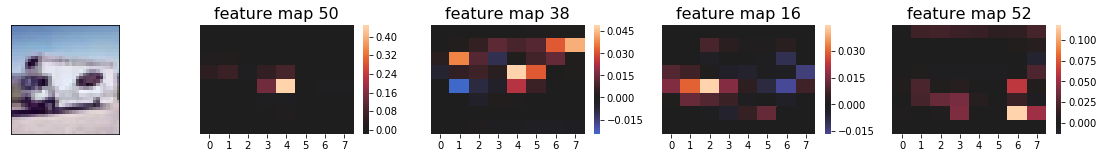

In [47]:
contribsW = predCheck(model, -2, x_cond, y_cond, w_ind[6], topFMs2, pred, label, figsize1 = (20,2))

predicted as airplane with proba 0.9988807
Is actually a airplane


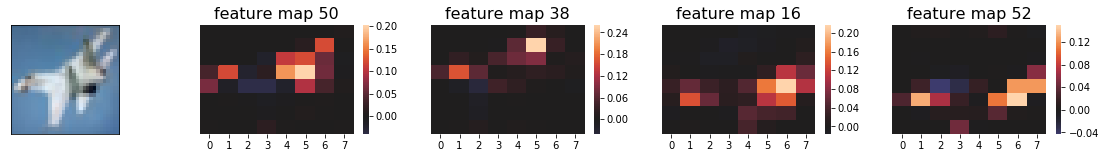

In [48]:
contribsR = predCheck(model, -2, x_cond, y_cond, r_ind[0], topFMs2, pred, label, figsize1 = (20,2))

In [49]:
contribsW

[(50, 0.012548336),
 (0, 0.012154854),
 (52, 0.008714764),
 (39, 0.0072344793),
 (29, 0.0071870876),
 (41, 0.0058835377),
 (37, 0.0052879695),
 (13, 0.0050468766),
 (32, 0.004364269),
 (59, 0.0041893832),
 (28, 0.0041550454),
 (38, 0.0040736734),
 (19, 0.0038690981),
 (27, 0.0035455755),
 (18, 0.0032143479),
 (14, 0.0028015715),
 (36, 0.002283552),
 (17, 0.0022076317),
 (9, 0.0020059508),
 (26, 0.0019690439),
 (16, 0.0019427502),
 (61, 0.0017447841),
 (62, 0.001683717),
 (63, 0.0016792067),
 (2, 0.0015162532),
 (54, 0.001299683),
 (48, 0.0011588132),
 (60, 0.0010477793),
 (25, 0.00046805825),
 (44, 0.00046451876),
 (7, 0.000197373),
 (51, 0.00010206756),
 (11, 0.0),
 (53, -0.00010688217),
 (30, -0.00015734033),
 (55, -0.0002677899),
 (34, -0.00042879846),
 (58, -0.00044258032),
 (6, -0.0006622394),
 (20, -0.00075689325),
 (46, -0.0012977335),
 (3, -0.0013672693),
 (24, -0.0015931238),
 (1, -0.0016415947),
 (31, -0.0016605638),
 (33, -0.0016673204),
 (56, -0.0018537446),
 (4, -0.0023586

In [50]:
contribsR

[(16, 0.023331594),
 (50, 0.017350378),
 (38, 0.016502403),
 (52, 0.013961033),
 (39, 0.012720967),
 (17, 0.0100668045),
 (59, 0.008099088),
 (13, 0.007946423),
 (0, 0.007931602),
 (2, 0.0079040965),
 (41, 0.0074429316),
 (37, 0.007150465),
 (19, 0.0061497586),
 (32, 0.005719906),
 (27, 0.0056402343),
 (14, 0.005322379),
 (36, 0.003769604),
 (53, 0.003342307),
 (28, 0.00308698),
 (29, 0.0029193382),
 (7, 0.002582486),
 (42, 0.002290532),
 (25, 0.001987173),
 (18, 0.0016380595),
 (44, 0.0015017446),
 (46, 0.0014086292),
 (55, 0.0013144207),
 (62, 0.0012091657),
 (34, 0.0007310519),
 (33, 0.0005161626),
 (35, 0.0003623337),
 (30, 0.00022295839),
 (24, 0.00010747614),
 (26, 5.254949e-05),
 (40, 6.43728e-06),
 (11, -1.9588324e-06),
 (9, -8.4637286e-05),
 (51, -0.0001755454),
 (60, -0.00017724928),
 (31, -0.00043986694),
 (6, -0.00092640315),
 (21, -0.0012246277),
 (3, -0.0013288268),
 (61, -0.0013498019),
 (20, -0.0017541752),
 (4, -0.0017902638),
 (56, -0.0018414691),
 (48, -0.0021533314)

check if sum of cond is equal to pre softmax value

In [5]:
def pre_softmax(x, ind):
    array = np.expand_dims(x[ind],0)
    ref_array = np.zeros_like(array)
    sess = K.get_session()
    input_tensor = model.input
    feed_dict = {input_tensor: np.concatenate((array, ref_array), 0)}
    out = model.layers[-2].output
    weights, bias = model.layers[-1].weights
    output_tensor = tf.add(tf.matmul(out,weights),bias)
    Fx, FxPrime = sess.run(output_tensor, feed_dict = feed_dict)
    res = model.predict(array)[0]
    pred = np.argmax(res)
    diff = Fx - FxPrime
    return Fx, FxPrime, pred, res

In [6]:
FxW, FxPrimeW, predW, resW = pre_softmax(x_train, 0)
diffW = FxW - FxPrimeW
diffW

array([-8.831204 , -7.1204414, -2.5487046, -1.4369621, -2.8570337,
        1.0138143,  5.265209 , -2.481142 , -3.8618493, -5.3846083],
      dtype=float32)

In [111]:
def cond_to_softmax(FxPrime, contribs):
    soft = []
    for c in range(num_class):
        score = np.exp(FxPrime[c])
        for i in range(contribs[c].shape[0]):
            for j in range(contribs[c].shape[1]):
                for k in range(contribs[c].shape[2]):
                    score *= np.exp(contribs[c][i,j,k])
        soft.append(score)
    exps = np.sum(soft)
    soft = [sof/exps for sof in soft]
    return soft

In [7]:
def softmax(entry):
    exps = np.sum([np.exp(x) for x in entry])
    entry = np.exp(entry)/exps
    return entry

In [8]:
softmax(FxW)

array([4.8648388e-07, 2.2960471e-08, 3.9801060e-04, 5.6719751e-04,
       2.4682647e-04, 6.0991303e-04, 9.9810457e-01, 1.0044751e-05,
       6.2510764e-05, 3.0385692e-07], dtype=float32)

In [9]:
model.predict(x_train[:1])

array([[4.86483714e-07, 2.29604193e-08, 3.98010685e-04, 5.67197974e-04,
        2.46826734e-04, 6.09913259e-04, 9.98104692e-01, 1.00447705e-05,
        6.25108005e-05, 3.03856780e-07]], dtype=float32)

In [10]:
def quickCond(model, num_class, interLayer, x, ind):
    array = x[ind]
    pred = np.argmax(model.predict(array[None]))
    
    input_tensor, outputs, sess = layerInit(model, num_class, interLayer, True)

    grads,activs = integratedGrad(array, input_tensor, outputs, sess)
    grads, activs = np.array(grads), np.array(activs)
    delta_activs = activs[:,1:,:,:,:] - activs[:,:-1,:,:,:]
    contribs = np.sum(grads[:,:,1:,:,:]*delta_activs, axis = 2)
    contribs = np.squeeze(contribs, axis = 1)
    
    return contribs

In [38]:
contribs = quickCond(model, num_class, [convLayers[-9]], x_train,0)

In [39]:
a = np.sum(contribs, axis = (1,2,3))
a

array([-9.154191 , -7.994196 , -2.8135748, -1.5629722, -2.7224855,
        1.1322576,  5.7457128, -2.6640239, -5.216105 , -6.315549 ],
      dtype=float32)

In [40]:
diffW

array([-8.831204 , -7.1204414, -2.5487046, -1.4369621, -2.8570337,
        1.0138143,  5.265209 , -2.481142 , -3.8618493, -5.3846083],
      dtype=float32)

In [41]:
softmax(a)

array([3.3435003e-07, 1.0665491e-06, 1.8962519e-04, 6.6225586e-04,
       2.0770912e-04, 9.8072952e-03, 9.8888856e-01, 2.2021412e-04,
       1.7158938e-05, 5.7148918e-06], dtype=float32)

In [42]:
softmax(diffW)

array([7.4266683e-07, 4.1093108e-06, 3.9741938e-04, 1.2080160e-03,
       2.9197350e-04, 1.4009782e-02, 9.8353249e-01, 4.2519788e-04,
       1.0689504e-04, 2.3314802e-05], dtype=float32)

In [44]:
pred = np.argmax(model.predict(x_train), axis = 1)
label = np.argmax(y_train, axis = 1)
w = pred != label 
w_ind = np.arange(len(w))[w]

In [49]:
FxW, FxPrimeW, predW, resW = pre_softmax(x_train, w_ind[0])
diffW = FxW - FxPrimeW
diffW

array([-4.9608645,  4.9650626, -3.5870275, -4.946526 , -6.49353  ,
       -4.8252525, -3.0593395, -4.7507825, -3.6715941,  4.8386755],
      dtype=float32)

In [70]:
#all layer prediction with conductance
fg = []
for l in range(len(convLayers)):
    contribs = quickCond(model, num_class, [convLayers[l]], x_train, w_ind[2])
    a = np.sum(contribs, axis = (1,2,3))
    qs = softmax(a+FxPrimeW)
    fg.append(np.argmax(qs))

In [71]:
fg

[6, 6, 6, 6, 6, 6, 4, 6, 6]

In [73]:
pred[w_ind[2]], label[w_ind[2]]

(6, 3)

DISPLAY OF CONTESTED IMAGES

In [150]:
wrongs = pickle.load(open("wrong_train_cond.p", "rb"))
finalWrongs = process_cond(convLayers, topFMs, topMeans, wrongs, num_class)
balanced_rights = pickle.load(open('balanced_rights.p', 'rb'))
finalRights = process_cond(convLayers, topFMs, topMeans, balanced_rights, num_class)
LCRW = pickle.load(open('LCRW.p', 'rb'))
LCRR = pickle.load(open('LCRR.p', 'rb'))
more_rights = pickle.load(open('more_rights.p', 'rb'))
more_finalRights = process_cond(convLayers, topFMs, topMeans, more_rights, num_class)
more_LCRR = pickle.load(open('more_LCRR.p', 'rb'))
more_finalWrongs, _ = augment(finalWrongs, LCRW, more_finalRights, more_LCRR, num_class)

NameError: name 'topFMs' is not defined

In [36]:
finalWrongs = np.concatenate((finalWrongs, more_finalWrongs), axis = 0)
finalRights = np.concatenate((finalRights, more_finalRights), axis = 0)
brut_data = np.concatenate((finalWrongs,finalRights), axis = 0)
y_wrongs = np.zeros(len(finalWrongs))
y_rights = np.ones(len(finalRights))
brut_labels = np.concatenate((y_wrongs,y_rights), axis = 0)

In [39]:
trainD, trainL, testD, testL,rnd = verif_data(9, rank, num_class, brut_data, brut_labels, False)  #wrongs is 0, rights is 1
rnd

brut data shape is  (19792, 46)


array([10815, 15643,  8744, ...,  9845, 10799,  2732])

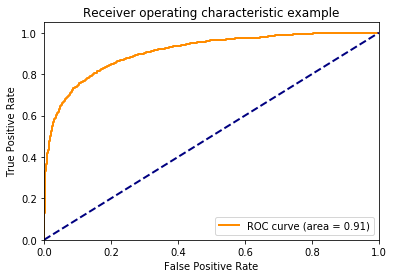

0.47706056


In [40]:
verif_pred = verif.predict(testD)
thresh = find_opti_thresh(testL, verif_pred, plot = True)
print(thresh)

In [15]:
binary_res = verif.predict(finalTestCond)
binary_lab = pred == label

In [60]:
w_contested_ind = binary_res[w_ind] < thresh
w_contested_ind = np.squeeze(w_contested_ind, 1)
w_ncontested_ind = binary_res[w_ind] >= thresh
w_ncontested_ind = np.squeeze(w_ncontested_ind, 1)
w_contested = w_ind[w_contested_ind]
w_ncontested = w_ind[w_ncontested_ind]

In [64]:
r_contested_ind = binary_res[r_ind] < thresh
r_contested_ind = np.squeeze(r_contested_ind, 1)
r_contested = r_ind[r_contested_ind]

In [100]:
def print_img(contested_list, ind, L, figsize):
    array = x_test[L][contested_list[ind]]
    res = model.predict(np.expand_dims(array, axis = 0))[0]
    pred = np.argmax(res)
    label = np.argmax(y_test[L][contested_list[ind]])
    img = image.array_to_img(array)
    
    data = finalTestCond[contested_list[ind]].reshape((1,-1))
    score = verif.predict(data).item()
    
    print("predicted as "+index_to_label[pred]+' with proba '+str(res[pred]))
    print('Is actually a '+str(index_to_label[label]))
    print("the score is: "+str(score)+ ' the threshold is: '+str(0.477))
    fig, axes = plt.subplots(1,1, figsize = figsize)
    axes.imshow(img)

predicted as airplane with proba 0.8458881
Is actually a horse
the score is: 0.5501914024353027 the threshold is: 0.477


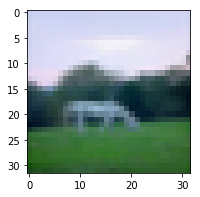

In [169]:
print_img(w_ncontested, 19, L, figsize = (8,3))

BARPLOTS

In [11]:
# allTopTrain = pickle.load(open('train_cond.p','rb'))
# wrongs = pickle.load(open("wrong_train_cond.p", "rb"))

In [29]:
allTopTrain = pickle.load(open('allClassCond2.p', 'rb'))
wrongs = pickle.load(open('wrongs2.p', 'rb'))

In [31]:
layer_num = len(convLayers) - 1
lastRLayer = [[allTopTrain[c][i][layer_num] for i in range(len(allTopTrain[c]))] for c in range(num_class)]
lastWLayer = [[wrongs[c][i][layer_num] for i in range(len(wrongs[c]))] for c in range(num_class)]

In [33]:
for c in range(num_class):
    classL = lastRLayer[c]
#     classL = [sorted(ov, key = lambda x: x[0]) for ov in classL]
#     classL = [[ovv[1] for ovv in ov] for ov in classL]
    lastRLayer[c] = np.array(classL)
    lastWLayer[c] = np.array(lastWLayer[c])
meanLastRLayer = [np.mean(classL, axis = 0) for classL in lastRLayer]
meanLastWLayer = [np.mean(classL, axis = 0) for classL in lastWLayer]

In [34]:
for c in range(num_class):
    lastRLayer[c] = np.array(lastRLayer[c])
    lastWLayer[c] = np.array(lastWLayer[c])
meanLastRLayer = [np.mean(classL, axis = 0) for classL in lastRLayer]
meanLastWLayer = [np.mean(classL, axis = 0) for classL in lastWLayer]
maxRMean = [np.max(m) for m in meanLastRLayer]
maxWMean = [np.max(m) for m in meanLastWLayer]
maxMean = [max(maxRMean[i], maxWMean[i]) for i in range(len(maxRMean))]
minRMean = [np.min(m) for m in meanLastRLayer]
minWMean = [np.min(m) for m in meanLastWLayer]
minMean = [min(minRMean[i], minWMean[i]) for i in range(len(minRMean))]

In [36]:
check = list(meanLastRLayer[0])
check = [(i,check[i]) for i in range(len(check))]
check = sorted(check, key = lambda x: x[1], reverse = True)
check

[(16, 0.015834663),
 (38, 0.014085925),
 (13, 0.008269005),
 (29, 0.0075864317),
 (27, 0.0070664287),
 (43, 0.0061575305),
 (52, 0.0058712955),
 (18, 0.0049723624),
 (14, 0.0045553166),
 (39, 0.004528577),
 (60, 0.0042648036),
 (28, 0.0042424556),
 (0, 0.0040713884),
 (9, 0.0039726556),
 (37, 0.0037753338),
 (63, 0.003730613),
 (41, 0.0036937608),
 (36, 0.0035051336),
 (33, 0.0032904467),
 (19, 0.0027318401),
 (25, 0.0025050717),
 (50, 0.0024261016),
 (31, 0.0021927268),
 (55, 0.0020629477),
 (17, 0.0020439562),
 (48, 0.0019086085),
 (32, 0.0016293157),
 (11, 0.0013693577),
 (59, 0.0011653919),
 (51, 0.0008728051),
 (7, 0.0007233832),
 (12, 0.00069006457),
 (44, 0.00056505576),
 (61, 0.0002788992),
 (5, 0.00021933901),
 (62, 5.1215622e-05),
 (22, -1.5833954e-05),
 (24, -9.156508e-05),
 (58, -0.00033522552),
 (46, -0.00036263853),
 (4, -0.00049313804),
 (34, -0.0005553805),
 (30, -0.0006769585),
 (56, -0.0007750299),
 (2, -0.0008498838),
 (1, -0.000875673),
 (3, -0.0009914371),
 (8, -0.

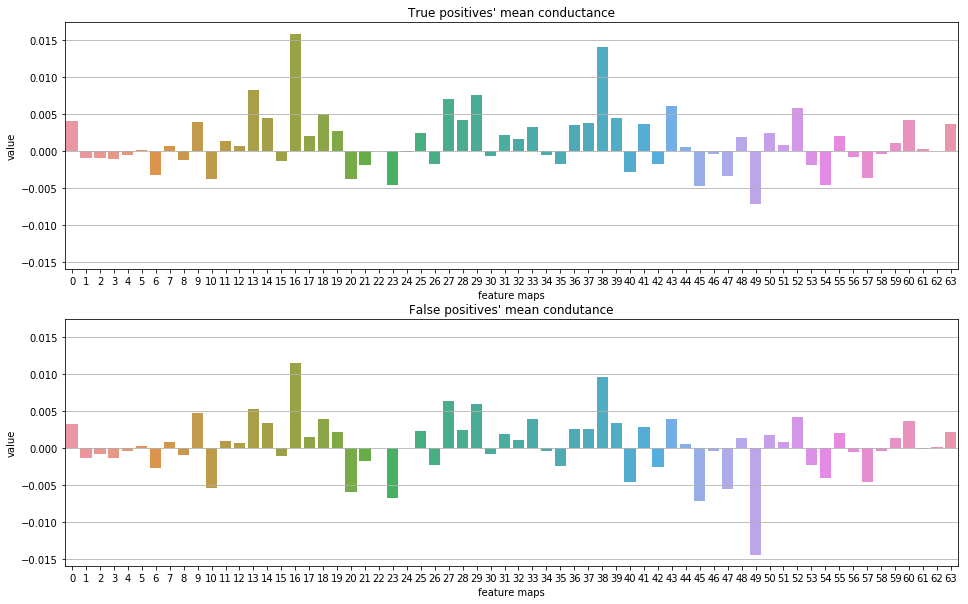

In [37]:
class_ind = 0
fig, axes = plt.subplots(2,1, figsize = (16,10))
axes[0].yaxis.grid(True)
axes[0].set_title('True positives\' mean conductance')
axes[0].set_ylabel('value')
axes[0].set_xlabel('feature maps')
axes[0].set_ylim(minMean[class_ind]+minMean[class_ind]/10, maxMean[class_ind]+maxMean[class_ind]/10)
axes[1].yaxis.grid(True)
axes[1].set_title('False positives\' mean condutance')
axes[1].set_ylabel('value')
axes[1].set_xlabel('feature maps')
axes[1].set_ylim(minMean[class_ind]+minMean[class_ind]/10, maxMean[class_ind]+maxMean[class_ind]/10)
sns.barplot(x = np.arange(lastRLayer[c].shape[1]), y = meanLastRLayer[class_ind], ax = axes[0])
sns.barplot(x = np.arange(lastWLayer[c].shape[1]), y = meanLastWLayer[class_ind], ax = axes[1])

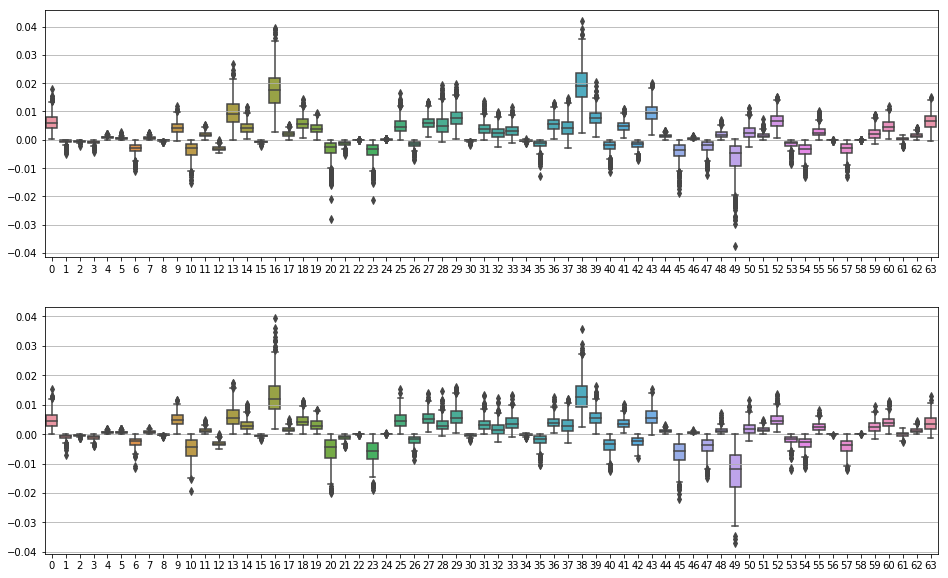

In [104]:
class_ind = 0
fig, axes = plt.subplots(2,1, figsize = (16,10))
axes[0].xaxis.grid(True)
axes[0].yaxis.grid(True)
axes[1].xaxis.grid(True)
axes[1].yaxis.grid(True)
sns.boxplot(data = lastRLayer[class_ind], ax = axes[0])
sns.boxplot(data = lastWLayer[class_ind], ax = axes[1])

CALC THE COND OF AN IMAGE

In [6]:
#calc_the_cond_of_an_image.py

BUILD COND STAT FOR WRONG IMG

In [7]:
#build_cond_stat_for_wrong.py